# Import Library

Impor library yang diperlukan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")


# Data Loading & Persiapan Awal

Menggabungkan file CSV

In [2]:
file_paths = [
    'umkm_dataset/data_transaksi_umkm_2022.csv',
    'umkm_dataset/data_transaksi_umkm_2023.csv',
    'umkm_dataset/data_transaksi_umkm_2024.csv',
    'umkm_dataset/data_transaksi_umkm_2025.csv',
    'umkm_dataset/data_transaksi_umkm_nasi_padang.csv',
    'umkm_dataset/data_transaksi_umkm_sinar_baledo.csv'
]

In [3]:
dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

Cek struktur dasar DataFrame

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112155 entries, 0 to 112154
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   tanggal    112155 non-null  object
 1   jenis      112155 non-null  object
 2   nama       112155 non-null  object
 3   kategori   112155 non-null  object
 4   nominal    112155 non-null  int64 
 5   Nama Toko  112155 non-null  object
dtypes: int64(1), object(5)
memory usage: 5.1+ MB


In [5]:
df.head()

,tanggal,jenis,nama,kategori,nominal,Nama Toko
0,2022-01-01,pemasukan,Penjualan Mie Ayam,penjualan,90000,Warung bu sholeh
1,2022-01-01,pemasukan,Penjualan Pecel Lele,penjualan,78000,Warung bu sholeh
2,2022-01-01,pemasukan,Penjualan Bakso,penjualan,22000,Warung bu sholeh
3,2022-01-01,pemasukan,Penjualan Ayam Bakar,penjualan,150000,Warung bu sholeh
4,2022-01-01,pemasukan,Penjualan Jus Alpukat,penjualan,78000,Warung bu sholeh


# Data Preprocessing & Ekstraksi Fitur Harian

 Mengolah semua transaksi lalu menghasilkan DataFrame “daily” yang berisi ringkasan (aggregate) setiap hari per toko

Standarisasi nama kolom

In [6]:
df.columns = df.columns.str.lower()

Konversi tanggal menjadi tipe datetime

In [7]:
df['tanggal'] = pd.to_datetime(df['tanggal'])

Memisahkan nominal menjadi kolom “pemasukan” dan “pengeluaran”

In [8]:
df['pengeluaran'] = df.apply(lambda row: row['nominal'] if row['jenis'] == 'pengeluaran' else 0, axis=1)
df['pemasukan'] = df.apply(lambda row: row['nominal'] if row['jenis'] == 'pemasukan' else 0, axis=1)

Tambah kolom 'periode_minggu' (akhir periode Senin)

In [9]:
df['periode_minggu'] = df['tanggal'].dt.to_period('W-MON').apply(lambda r: r.start_time)

Agregasi per minggu

In [10]:
weekly = (
    df
    .groupby(['nama toko', 'periode_minggu'])
    .agg({
        'pemasukan':   'sum',
        'pengeluaran': 'sum',
        'nominal':     'count'   # ini akan jadi jumlah_transaksi
    })
    .rename(columns={'nominal': 'jumlah_transaksi'})
    .reset_index()
)

Tambahkan kolom 'laba_bersih' & 'rasio_keuangan'

In [11]:
weekly['laba_bersih'] = weekly['pemasukan'] - weekly['pengeluaran']
weekly['rasio_keuangan'] = weekly['pemasukan'] / (weekly['pengeluaran'] + 1)

hitung jumlah hari rugi perminggu

In [12]:
harian = (
    df
    .groupby(['nama toko', 'tanggal'])
    .agg({'pemasukan': 'sum', 'pengeluaran': 'sum'})
    .reset_index()
)
harian['flag_rugi'] = (harian['pengeluaran'] > harian['pemasukan']).astype(int)
harian['periode_minggu'] = harian['tanggal'].dt.to_period('W-MON').apply(lambda r: r.start_time)

hari_rugi_per_minggu = (
    harian
    .groupby(['nama toko', 'periode_minggu'])['flag_rugi']
    .sum()
    .reset_index(name='jumlah_hari_rugi')
)

Merge jumlah_hari_rugi ke weekly

In [13]:
weekly = weekly.merge(
    hari_rugi_per_minggu,
    on=['nama toko', 'periode_minggu'],
    how='left'
)


In [14]:
weekly['jumlah_hari_rugi'] = weekly['jumlah_hari_rugi'].fillna(0).astype(int)

In [15]:
weekly.head()

,nama toko,periode_minggu,pemasukan,pengeluaran,jumlah_transaksi,laba_bersih,rasio_keuangan,jumlah_hari_rugi
0,RM Sinar Balatas,2021-12-28,5818000,14545701,99,-8727701,0.399981,2
1,RM Sinar Balatas,2022-01-04,12660000,13309240,206,-649240,0.951219,2
2,RM Sinar Balatas,2022-01-11,12046000,13070540,197,-1024540,0.921614,1
3,RM Sinar Balatas,2022-01-18,11948000,12144892,188,-196892,0.983788,2
4,RM Sinar Balatas,2022-01-25,12354000,12621995,195,-267995,0.978768,2


Menentukan Label Multi‐Kelas

In [16]:
def kategori_laba(row):
    rasio = row['rasio_keuangan']
    if rasio >= 1.2:
        return 'Sehat'
    elif rasio >= 1.0:
        return 'Cukup Sehat'
    elif rasio >= 0.8:
        return 'Perlu Perhatian'
    else:
        return 'Perlu Penanganan Khusus'

weekly['label_kelas'] = weekly.apply(kategori_laba, axis=1)

# Tampilkan distribusi label
print(weekly['label_kelas'].value_counts())


label_kelas
Cukup Sehat                144
Sehat                      136
Perlu Perhatian            129
Perlu Penanganan Khusus    116
Name: count, dtype: int64


In [17]:
weekly.head()

,nama toko,periode_minggu,pemasukan,pengeluaran,jumlah_transaksi,laba_bersih,rasio_keuangan,jumlah_hari_rugi,label_kelas
0,RM Sinar Balatas,2021-12-28,5818000,14545701,99,-8727701,0.399981,2,Perlu Penanganan Khusus
1,RM Sinar Balatas,2022-01-04,12660000,13309240,206,-649240,0.951219,2,Perlu Perhatian
2,RM Sinar Balatas,2022-01-11,12046000,13070540,197,-1024540,0.921614,1,Perlu Perhatian
3,RM Sinar Balatas,2022-01-18,11948000,12144892,188,-196892,0.983788,2,Perlu Perhatian
4,RM Sinar Balatas,2022-01-25,12354000,12621995,195,-267995,0.978768,2,Perlu Perhatian


# Data Preparation

Persiapan Data untuk Model



Membuat fitur turunan

Untuk `rasio_transaksi`
> *"Rasio ini saya gunakan untuk mengukur efisiensi aktivitas transaksi terhadap pengeluaran. Semakin tinggi nilainya, berarti setiap unit pengeluaran menghasilkan lebih banyak transaksi. Penambahan +1 pada penyebut bertujuan untuk menghindari pembagian dengan nol ketika tidak ada pengeluaran. Konsep dasarnya mirip dengan rasio efisiensi dalam analisis keuangan, meskipun ini disesuaikan untuk konteks data mingguan."*

Untuk `persen_pengeluaran`
> *"Rasio ini menunjukkan seberapa besar proporsi pengeluaran dibanding total arus kas (pemasukan + pengeluaran). Ini berguna untuk memahami dominasi belanja terhadap keseluruhan aktivitas keuangan. Nilai kecil 1e-9 ditambahkan untuk mencegah error pembagian nol. Ini mirip dengan pendekatan proporsi dalam laporan keuangan atau rasio cost-to-income di sektor keuangan."*

Rumus ini bukan dari literatur tunggal, tapi merupakan bentuk praktik umum dalam data analysis — konsepnya terinspirasi dari rasio efisiensi dan rasio aktivitas keuangan. [Financial Analysis Ratio](https://www.jurnal.id/id/blog/rumus-rasio-keuangan-untuk-analisis-rasio-keuangan-perusahaan/?utm_source=chatgpt.com)

In [18]:
# Buat fitur turunan:
weekly['rasio_transaksi'] = weekly['jumlah_transaksi'] / (weekly['pengeluaran'] + 1)
weekly['persen_pengeluaran'] = weekly['pengeluaran'] / (weekly['pemasukan'] + weekly['pengeluaran'] + 1e-9)

# Pilih fitur yang TIDAK memuat pemasukan/pengeluaran secara mentah
features = [
    'pemasukan',
    'pengeluaran',
    'jumlah_transaksi',
    'jumlah_hari_rugi',
    'rasio_transaksi',
    'persen_pengeluaran'
]

In [19]:
X = weekly[features]
y = weekly['label_kelas']

Encode Label Menjadi Numerik

In [20]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Mapping label:", dict(zip(le.classes_, le.transform(le.classes_))))

# One-hot encoding untuk klasifikasi multi-kelas
y_cat = to_categorical(y_enc)

Mapping label: {'Cukup Sehat': np.int64(0), 'Perlu Penanganan Khusus': np.int64(1), 'Perlu Perhatian': np.int64(2), 'Sehat': np.int64(3)}


Normalisasi

In [21]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Split data menjadi training & testing

In [22]:
X_train, X_test, y_train_cat, y_test_cat, y_train_enc, y_test_enc = train_test_split(
    X_scaled, y_cat, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)


pembuatan Model

In [23]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax')  # 4 kelas output
])

In [24]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Pelatihan Model

In [25]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [26]:
history = model.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stop]
)


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.2200 - loss: 1.3922 - val_accuracy: 0.2619 - val_loss: 1.3655
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3226 - loss: 1.3578 - val_accuracy: 0.4048 - val_loss: 1.3387
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3756 - loss: 1.3304 - val_accuracy: 0.3095 - val_loss: 1.2968
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3986 - loss: 1.2914 - val_accuracy: 0.4048 - val_loss: 1.2246
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4324 - loss: 1.2243 - val_accuracy: 0.5238 - val_loss: 1.1212
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5395 - loss: 1.1159 - val_accuracy: 0.7857 - val_loss: 1.0027
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6192 - loss: 0.9732 - val_accuracy: 0.7381 - val_loss: 0.8956
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6019 - loss: 0.9216 - val_accuracy: 0.8333 -

In [27]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"\nTest Accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9449 - loss: 0.1753

Test Accuracy: 0.9429


In [28]:
# Prediksi kelas dari probabilitas
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Laporan klasifikasi
print("\n=== Classification Report (Neural Network Multi-Kelas) ===")
print(classification_report(y_test_enc, y_pred_classes, target_names=le.classes_))

# Confusion matrix
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_enc, y_pred_classes))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

=== Classification Report (Neural Network Multi-Kelas) ===
                         precision    recall  f1-score   support

            Cukup Sehat       0.87      0.93      0.90        29
Perlu Penanganan Khusus       1.00      1.00      1.00        23
        Perlu Perhatian       0.96      0.88      0.92        26
                  Sehat       0.96      0.96      0.96        27

               accuracy                           0.94       105
              macro avg       0.95      0.94      0.95       105
           weighted avg       0.94      0.94      0.94       105

=== Confusion Matrix ===
[[27  0  1  1]
 [ 0 23  0  0]
 [ 3  0 23  0]
 [ 1  0  0 26]]


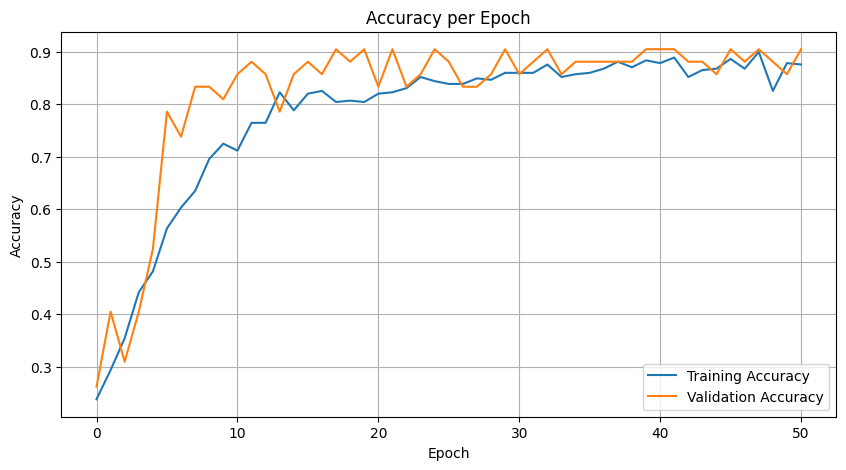

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [31]:
import os
import json

os.makedirs('analisis_kesehatan_bisnis/model_tfjs', exist_ok=True)

model.export('analisis_kesehatan_bisnis/model_tfjs/saved_model')

scaler_params = {
    'scale_': scaler.scale_.tolist(),
    'min_': scaler.min_.tolist(),
    'data_min_': scaler.data_min_.tolist(),
    'data_max_': scaler.data_max_.tolist(),
    'data_range_': scaler.data_range_.tolist(),
    'n_samples_seen_': scaler.n_samples_seen_
}
with open('analisis_kesehatan_bisnis/model_tfjs/scaler_params.json', 'w') as f:
    json.dump(scaler_params, f)

label_classes = le.classes_.tolist()
with open('analisis_kesehatan_bisnis/model_tfjs/label_classes.json', 'w') as f:
    json.dump(label_classes, f)

Saved artifact at 'analisis_kesehatan_bisnis/model_tfjs/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132122532386128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132122532388432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132122532390544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132122532388240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132122532387664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132122532390736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132122532389008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132122532391888: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [35]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model --signature_name=serving_default --saved_model_tags=serve analisis_kesehatan_bisnis/model_tfjs/saved_model analisis_kesehatan_bisnis/model_tfjs

2025-05-24 07:29:31.057065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748071771.092557    6733 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748071771.102596    6733 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-24 07:29:39.059601: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1748071779.059776    6733 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

inference Model

In [32]:
def prediksi_kondisi_keuangan(data_baru: pd.DataFrame):
    print(">> Mulai prediksi")

    data_baru['rasio_transaksi'] = data_baru['jumlah_transaksi'] / (data_baru['pengeluaran'] + 1)
    data_baru['persen_pengeluaran'] = data_baru['pengeluaran'] / (data_baru['pemasukan'] + data_baru['pengeluaran'] + 1e-9)

    features = [
        'pemasukan',
        'pengeluaran',
        'jumlah_transaksi',
        'jumlah_hari_rugi',
        'rasio_transaksi',
        'persen_pengeluaran'
    ]
    X_new = data_baru[features]
    X_new_scaled = scaler.transform(X_new)

    print(">> Transformasi selesai, mulai prediksi")
    y_probs = model.predict(X_new)
    print(">> Probabilitas:", y_probs)

    y_pred_class = np.argmax(y_probs, axis=1)
    label_pred = le.inverse_transform(y_pred_class)

    print(">> Hasil kelas:", label_pred)
    return label_pred[0]


In [33]:
# Contoh data baru yang ingin diprediksi
data_baru = pd.DataFrame([{
    'pemasukan': 3000000,
    'pengeluaran': 2950000,
    'jumlah_transaksi': 12,
    'jumlah_hari_rugi': 6
}])

# Panggil fungsi prediksi dan tampilkan hasil
hasil = prediksi_kondisi_keuangan(data_baru)
print("Prediksi kondisi keuangan:", hasil)


>> Mulai prediksi
>> Transformasi selesai, mulai prediksi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
>> Probabilitas: [[1. 0. 0. 0.]]
>> Hasil kelas: ['Cukup Sehat']
Prediksi kondisi keuangan: Cukup Sehat


In [36]:
import shutil

shutil.make_archive('model_tfjs_export', 'zip', 'analisis_kesehatan_bisnis/model_tfjs')

'/content/model_tfjs_export.zip'